In [1]:
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sys
sys.path.append('../../zdrojaky')
from tsplot import *
import warnings
warnings.filterwarnings('ignore')

# AR(2) model ve `statsmodels`

Autoregresní model druhého řádu má tvar

$$
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Označme
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ Y_{t-1}
\end{bmatrix}
,\qquad
\mathbf{w}_t =
\begin{bmatrix}
\varepsilon_t \\ 0
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0
\end{bmatrix}
\mathbf{X}_{t-1} + \mathbf{w}_t.
\end{align}
$$

Parametry jsou tedy $\sigma^2, \phi_1, \phi_2$.

Pomůžeme si se statsmodels [Representation](http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.representation.Representation.html#statsmodels.tsa.statespace.representation.Representation) a [statespace](http://www.statsmodels.org/stable/statespace.html)

In [3]:
class AR2Model(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = 2
        k_posdef = 1

        # Initialize the statespace
        super(AR2Model, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design', 0, 0] = 1
        self.ssm['transition', 1, 0] = 1
        self.ssm['selection', 0, 0] = 1
        
    def update(self, params, *args, **kwargs):
        params = super(AR2Model, self).update(params, *args, **kwargs)
        
        # State noise covariance
        self.ssm['state_cov', 0, 0] = params[0]

        # Transition matrix
        self.ssm['transition', 0, :] = params[1:]  
        
    @property
    def param_names(self):
        return ['sigma2.process', 'phi.1', 'phi.2']

    @property
    def start_params(self):
        return [np.std(self.endog), 0, 0]

    def transform_params(self, params):
        sigma2 = params[0]**2
        return np.r_[sigma2, params[1], params[2]]

    def untransform_params(self, params):
        sigma2 = params[0]**0.5
        return np.r_[sigma2, params[1], params[2]] 

## Simulovaná testovací data

Připravíme si testovací data AR(2) procesu s šumem $\varepsilon_t \sim \mathcal{N}(0, 0.5)$ a koeficienty $\phi_1 = -0.8, \phi_2 = 0.2$.

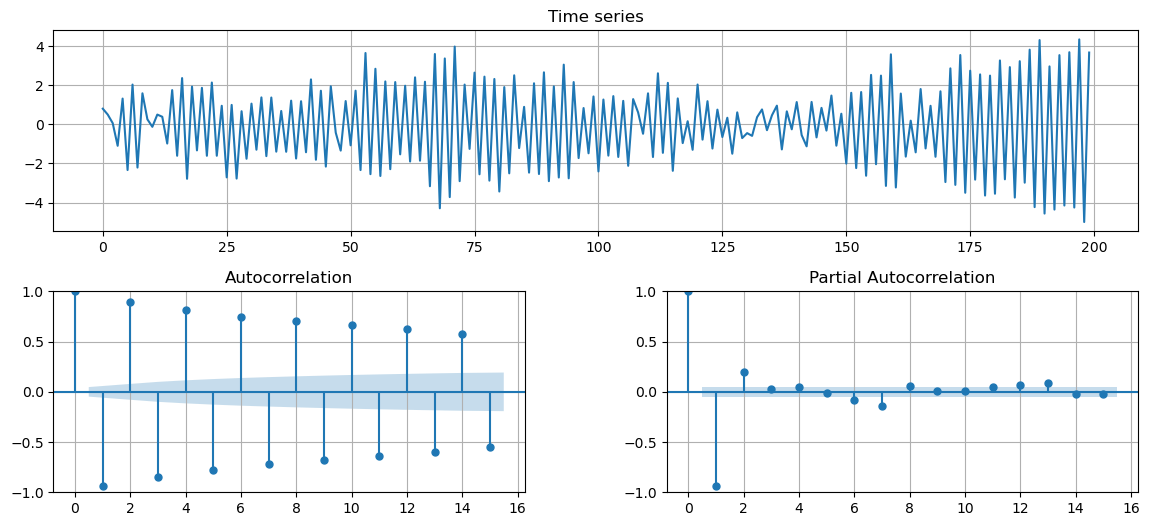

In [11]:
#%% Simulace
np.random.seed(12)
ndat = 200
noise_var = 0.5
noise = np.random.normal(scale=np.sqrt(noise_var), size=ndat)

Y = np.zeros(ndat)
Y[0:2] = np.array([.8, .5])
phi = np.array([-.7, .3])
for t in range(2, ndat):
    Y[t] = np.dot(np.flip(Y[t-2:t]), phi) + noise[t]

tsplot(Y)

Zkusíme je prohnat modelem a odhadnout "neznámé parametry" z přímo z dat.

In [12]:
model = AR2Model(Y)
res = model.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41995D+00    |proj g|=  2.07541D+00

At iterate    5    f=  1.20294D+00    |proj g|=  1.05691D+00

At iterate   10    f=  1.11560D+00    |proj g|=  5.87986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.770D-06   1.111D+00
  F =   1.1107233323280354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                   

 This problem is unconstrained.


Stejně jako v předchozím příkladu zkusíme rovněž udělat predikce na dalších `nsteps = 20` kroků dopředu.

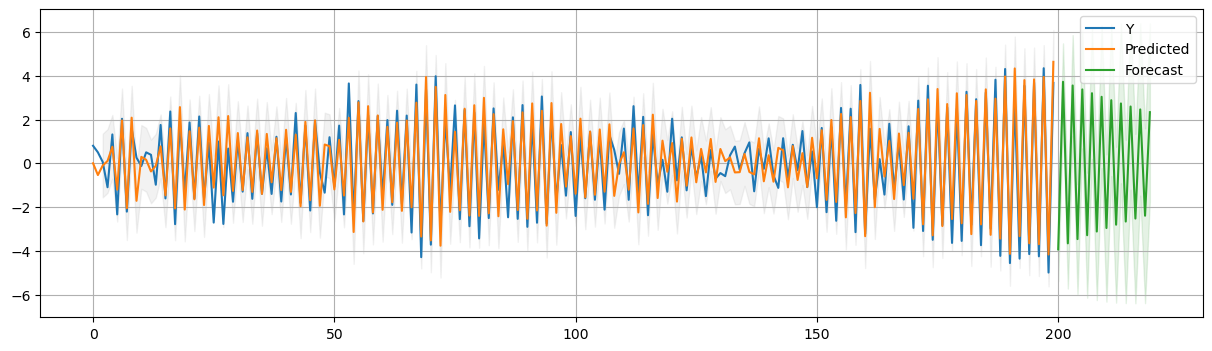

In [13]:
nsteps = 20
predict = res.get_prediction()
forecast = res.get_forecast(nsteps)

plt.figure(figsize=(15,4))
plt.plot(Y, label='Y')
plt.plot(predict.predicted_mean, label='Predicted')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
plt.fill_between(predict_index[2:], predict_ci[2:, 0], predict_ci[2:, 1], color='grey', alpha=0.1)
plt.plot(np.arange(ndat, ndat+nsteps), forecast.predicted_mean, label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
plt.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], color='green', alpha=0.1)
plt.legend()
plt.show()